# Autoencoders入门

 本教程通过三个例子介绍自动编码器:基础知识、图像去噪和异常检测。 自动编码器是一种特殊类型的神经网络，经过训练可以将输入复制到输出。例如，给定一幅手写数字的图像，自动编码器首先将该图像编码为低维的潜在表示，然后将该潜在表示解码为一幅图像。一个自动编码器学习压缩数据，同时尽量减少重建误差。 要了解更多关于自动编码器的信息，请考虑阅读Ian Goodfe的《深度学习》第14章

### 导入tenorflow和其他函数库

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

### 载入数据

开始，你将训练基本的自动编码器使用Fashon MNIST数据集。这个数据集中的每个图像都是28x28像素。

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


# 第一个例子：basic autoencoder

定义一个具有两个密集层的自动编码器:一个编码器，它将图像压缩成64维的潜在向量;一个解码器，它将从潜在空间重新构造原始图像。
要定义您的模型，请使用Keras模型子类化API。

In [3]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

使用x_train作为输入和目标来训练模型。编码器将学会压缩数据集从784维到潜在空间，解码器将学会重建原始图像。

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 138us/sample - loss: 0.0241 - val_loss: 0.0133
Epoch 2/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0115 - val_loss: 0.0105
Epoch 3/10
60000/60000 [==============================] - 8s 133us/sample - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0092 - val_loss: 0.0091
Epoch 6/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.0090 - val_loss: 0.0091
Epoch 7/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
60000/60000 [==============================] - 7s 122us/sample - loss: 0.00

现在模型已经训练好了，让我们通过对测试集的图像进行编码和解码来测试它。

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

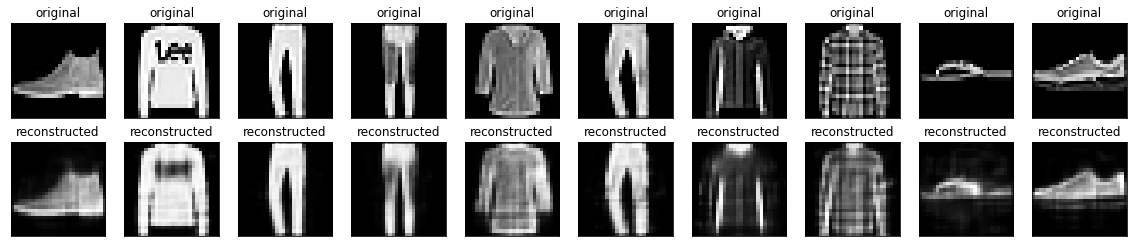

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# 第二个例子：图像降噪

让我们重新导入数据集以省略前面所做的修改。

In [8]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


给图像添加随机噪声

In [10]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

绘制嘈杂的图像。

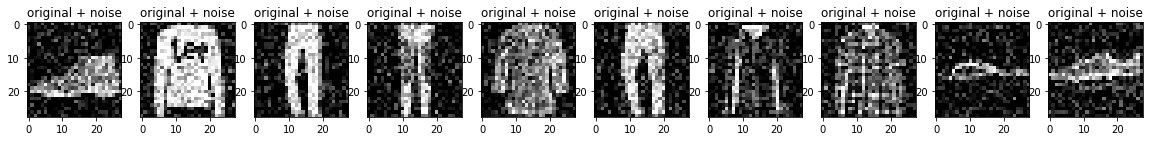

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### 定义卷积自动编码器

在这个例子中，你将在编码器中使用Conv2D层，在解码器中使用conv2d转置层来训练卷积自动编码器。

In [12]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)), 
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])
    
    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

让我们看一看编码器的摘要。注意图像是如何从28x28向下采样到7x7的。

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


解码器将图像从7x7采样回28x28

In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran multiple                  584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  1168      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


同时绘制由自动编码器产生的噪声图像和去噪图像。

In [17]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

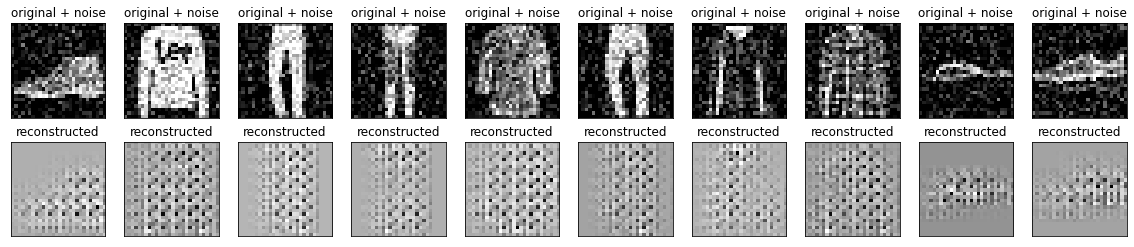

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# 第三个例子：异常检测

### 综述

在本例中，您将训练一个自动编码器来检测ECG5000数据集上的异常。这个数据集包含5,000个心电图，每个心电图有140个数据点。您将使用数据集的简化版本，其中每个示例被标记为0(对应于异常节奏)或1(对应于正常节奏)。你对识别异常节律感兴趣。

注意:这是一个带标签的数据集，所以您可以将其描述为一个监督学习问题。这个示例的目的是演示可以应用于没有标签的大型数据集的异常检测概念(例如，如果您有数千个正常节律，而只有少量的异常节律)。

如何使用自动编码器检测异常?回想一下，一个自动编码器是训练来最小化重构误差的。你将训练一个自动编码器的正常节奏，然后使用它来重建所有的数据。我们的假设是异常的节律会有更高的重构误差。如果重构误差超过一个固定的阈值，你将把一个节律归类为异常。

### 载入ECG数据

您将使用的数据集是基于timeseriesclassification.com的数据集。

In [19]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [20]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

将数据归一化为[0,1]。

In [21]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

您将只使用正常节奏(在此数据集中标记为1)来训练自动编码器。将正常节律与异常节律分开。

In [22]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

绘制正常心电图

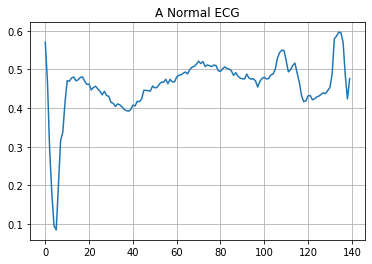

In [23]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

画一个异常心电图。

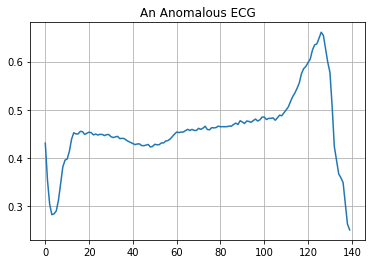

In [24]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### 建立模型

In [25]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [26]:
autoencoder.compile(optimizer='adam', loss='mae')

请注意，autoencoder只使用正常的心电图进行训练，但是使用完整的测试集进行评估。

In [27]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Train on 2359 samples, validate on 1000 samples
Epoch 1/20
2359/2359 [==============================] - 1s 403us/sample - loss: 0.0582 - val_loss: 0.0532
Epoch 2/20
2359/2359 [==============================] - 0s 24us/sample - loss: 0.0557 - val_loss: 0.0515
Epoch 3/20
2359/2359 [==============================] - 0s 25us/sample - loss: 0.0521 - val_loss: 0.0508
Epoch 4/20
2359/2359 [==============================] - 0s 23us/sample - loss: 0.0483 - val_loss: 0.0484
Epoch 5/20
2359/2359 [==============================] - 0s 24us/sample - loss: 0.0443 - val_loss: 0.0457
Epoch 6/20
2359/2359 [==============================] - 0s 22us/sample - loss: 0.0407 - val_loss: 0.0444
Epoch 7/20
2359/2359 [==============================] - 0s 25us/sample - loss: 0.0375 - val_loss: 0.0424
Epoch 8/20
2359/2359 [==============================] - 0s 31us/sample - loss: 0.0347 - val_loss: 0.0411
Epoch 9/20
2359/2359 [==============================] - 0s 26us/sample - loss: 0.0321 - val_loss: 0.0398
Epoch 

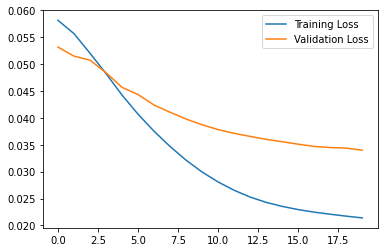

In [28]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

如果重构误差大于正常训练样本的一个标准偏差，您将很快将ECG诊断为异常。首先，让我们从训练集绘制一个正常的心电图，通过自动编码器对其进行编码和解码后的重构，以及重构误差。

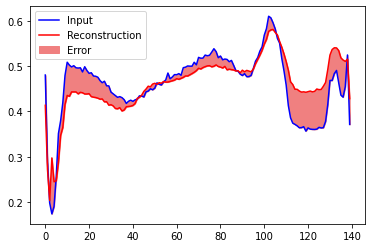

In [29]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

创建一个类似的图，这次是为了一个异常的测试示例。

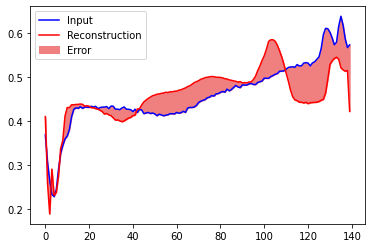

In [30]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### 检测异常

通过计算重构损失是否大于固定阈值来检测异常。在本教程中，您将计算训练集中正常示例的平均平均误差，然后如果重构误差比训练集中的一个标准偏差高，则将未来的示例分类为反常示例。

根据训练集在正常心电图上绘制重建误差

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

选择一个比平均值高出一个标准差的阈值。

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

注意:您可以使用其他策略来选择一个阈值，超过这个阈值，测试示例将被归类为反常，正确的方法将取决于您的数据集。您可以通过本教程末尾的链接了解更多内容。

如果你检查测试集中异常例子的重构误差，你会发现大多数重构误差都大于阈值。通过改变阈值，您可以调整分类器的精度和召回率

In [ ]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

如果重构误差大于阈值，则将ECG划分为异常。

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

# 下一步

要了解更多关于用自动编码器检测异常的知识，请查看这个由Victor Dibia用TensorFlow.js构建的优秀交互示例。在实际应用中，您可以了解空中客车如何使用TensorFlow检测国际空间站遥测数据中的异常情况。要了解更多基本知识，请考虑阅读Francois Chollet的这篇博客文章。要了解更多细节，请查看由伊恩·古德费勒、约舒亚·本乔和亚伦·考维尔合著的《深度学习》第14章。